## LOAD THE FILE

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/content/male_players (legacy).csv', na_values='-')

<ipython-input-6-a034ba37c97f>:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/content/male_players (legacy).csv', na_values='-')


## 1. DATA PREPARATION & FEATURE EXTRACTION

#### ***a) Removing columns with null rows greater than 40% of all the rows***

In [7]:
# Features with more than 40% missing values should be dropped
L_more = []
L_less = []
for i in df.columns:
    if((df[i].isnull().sum()) < (0.4*(df.shape[0]))):
        L_less.append(i)
    else:
        L_more.append(i)

In [8]:

df = df[L_less]

#### ***b) Selecting relevant features based on problem scope***

In [9]:
# Separating the data
import numpy as np
numeric_data = df.select_dtypes(include=np.number)
non_numeric = df.select_dtypes(include = ['object'])


In [10]:
# Drop irrelevant numerical-columns
numeric_data.drop(['player_id', 'fifa_version', 'fifa_update', 'club_team_id', 'club_jersey_number', 'club_contract_valid_until_year', 'nationality_id'], axis=1, inplace=True)

In [11]:
# Drop irrelevant non-numerical-columns
non_numeric.drop(['player_url', 'fifa_update_date'], axis=1, inplace=True)

### ***c) Imputing***

In [12]:
# IMPUTE THE NUMERIC DATA
# MULTIVARIABLE IMPUTATION
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 10, random_state=0)
numeric_data = pd.DataFrame(np.round(imp.fit_transform(numeric_data)), columns=numeric_data.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
# Mode imputation for NON-NUMERIC DATA
non_numeric['club_name'].fillna(df['club_name'].mode()[0], inplace=True)
non_numeric['league_name'].fillna(df['league_name'].mode()[0], inplace=True)
non_numeric['club_position'].fillna(df['club_position'].mode()[0], inplace=True)
non_numeric['club_joined_date'].fillna(df['club_joined_date'].mode()[0], inplace=True)

### ***d) Encoding Non-numerical Data***

##### ***i) Separating Binary and Non-Binary non-numerical data***

In [14]:
# NON-BINARY SUBSET
indices_to_exclude = [9, 13]
columns_to_keep = non_numeric.columns.difference(non_numeric.columns[indices_to_exclude])

non_binary = non_numeric[columns_to_keep]

# BINARY SUBSET
binary = non_numeric.iloc[:,9:13].iloc[:, [0, -1]]
non_binary.columns

Index(['body_type', 'cam', 'cb', 'cdm', 'cf', 'club_joined_date', 'club_name',
       'club_position', 'cm', 'dob', 'gk', 'lam', 'lb', 'lcb', 'lcm', 'ldm',
       'league_name', 'lf', 'lm', 'long_name', 'lw', 'lwb', 'nationality_name',
       'player_face_url', 'player_positions', 'ram', 'rb', 'rcb', 'rcm', 'rdm',
       'real_face', 'rf', 'rm', 'rs', 'rw', 'rwb', 'short_name', 'st',
       'work_rate'],
      dtype='object')

##### ***ii) LABEL ENCODING FOR BINARY NON-NUMERICAL DATA***

In [15]:
from sklearn.preprocessing import LabelEncoder # import the LabelEncoder
label_encoder = LabelEncoder() # Instantiation of the LabelEncoder

# Encode binary variables
binary['preferred_foot_encoded'] = label_encoder.fit_transform(df['preferred_foot'])
binary['real_face_encoded'] = label_encoder.fit_transform(df['real_face'])

binary_encoded = binary.iloc[:,2:]
binary_encoded #<--- non-comment to see output

,preferred_foot_encoded,real_face_encoded
0,0,1
1,1,1
2,0,1
3,1,1
4,1,1
...,...,...
161578,1,0
161579,0,0
161580,1,0
161581,1,0


### MERGING THE DATA

In [16]:
full_merged = pd.concat([numeric_data, binary_encoded], axis=1) # merging the binary-non numerical data and the numerical data
# full_merged  #<--- non-comment to see output

## 2. Create Feature Subsets Showing Maximum Correlation with the Dependent Variable

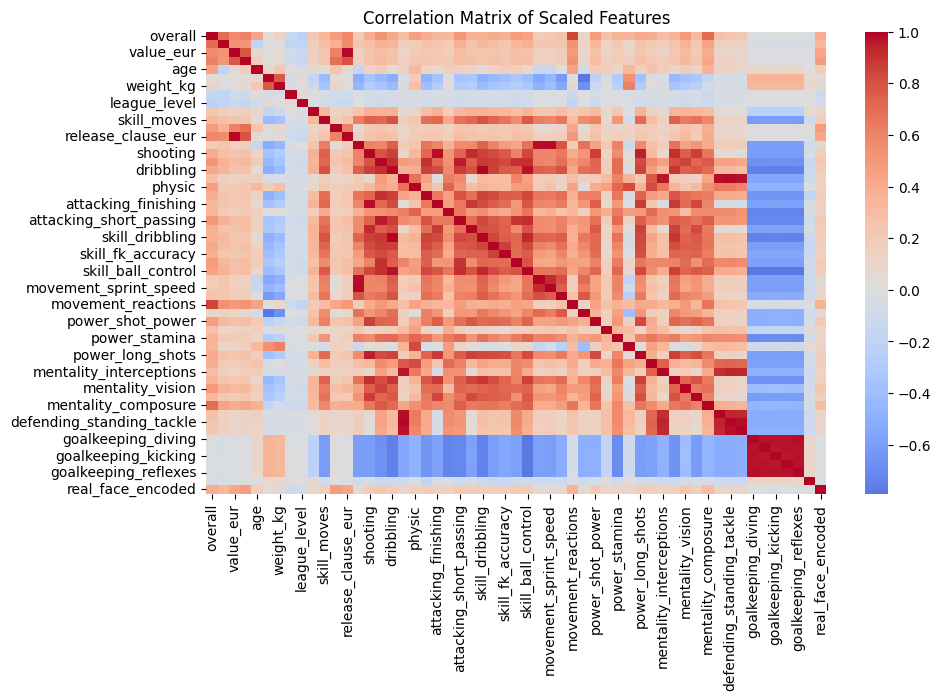

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(full_merged.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Scaled Features')
plt.show()


In [18]:
# Calculate correlation with the target variable 'overall'
correlation_matrix = full_merged.corr()

# Calculate correlations with the target variable "overall"
correlations = full_merged.corr()['overall'].sort_values(ascending=False)

# Select features with a high correlation with 'overall'
high_correlation_features = correlations[abs(correlations) > 0.4].index.tolist()

# Create a subset with the selected features
subset_df = full_merged[high_correlation_features]


In [19]:
subset_df.head()

,overall,movement_reactions,mentality_composure,potential,wage_eur,release_clause_eur,value_eur,passing,attacking_short_passing,mentality_vision,international_reputation,skill_long_passing,power_shot_power,physic,age,skill_ball_control,dribbling,skill_curve,power_long_shots,real_face_encoded
0,93.0,94.0,91.0,95.0,550000.0,186143215.0,100500000.0,86.0,89.0,90.0,5.0,76.0,80.0,63.0,27.0,96.0,96.0,89.0,88.0,1
1,92.0,90.0,90.0,92.0,375000.0,144448218.0,79000000.0,81.0,82.0,81.0,5.0,72.0,94.0,79.0,29.0,92.0,91.0,88.0,93.0,1
2,90.0,89.0,90.0,90.0,275000.0,100272311.0,54500000.0,83.0,86.0,84.0,5.0,76.0,86.0,64.0,30.0,90.0,92.0,85.0,90.0,1
3,90.0,85.0,92.0,90.0,275000.0,96925587.0,52500000.0,81.0,84.0,83.0,5.0,76.0,93.0,86.0,32.0,90.0,86.0,80.0,88.0,1
4,90.0,89.0,58.0,90.0,300000.0,116464674.0,63500000.0,33.0,42.0,20.0,5.0,41.0,42.0,62.0,28.0,31.0,33.0,25.0,25.0,1


##Scaling the independent Variables

In [20]:
from sklearn.preprocessing import StandardScaler

# Separate the independent variables and the target variable
X = subset_df.drop('overall', axis=1)
y = subset_df['overall']

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine scaled independent variables with the target variable for visualization if needed
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['overall'] = y.reset_index(drop=True)
scaled_df.head()

,movement_reactions,mentality_composure,potential,wage_eur,release_clause_eur,value_eur,passing,attacking_short_passing,mentality_vision,international_reputation,skill_long_passing,power_shot_power,physic,age,skill_ball_control,dribbling,skill_curve,power_long_shots,real_face_encoded,overall
0,3.535775,2.787723,3.875315,24.662645,16.768131,16.431555,2.309173,2.086204,2.588430,10.148137,1.536683,1.499832,0.020355,0.401872,2.281310,2.436147,2.306588,2.148684,3.220416,93.0
1,3.099571,2.704432,3.396013,16.657177,12.924109,12.833160,1.954660,1.609554,1.957672,10.148137,1.273977,2.401757,1.461498,0.830120,2.039859,2.117654,2.251267,2.411698,3.220416,92.0
2,2.990520,2.704432,3.076478,12.082624,8.851362,8.732664,2.096465,1.881925,2.167924,10.148137,1.536683,1.886371,0.110427,1.044244,1.919133,2.181353,2.085305,2.253890,3.220416,90.0
3,2.554317,2.871013,3.076478,12.082624,8.542815,8.397930,1.954660,1.745740,2.097840,10.148137,1.536683,2.337334,2.091997,1.472491,1.919133,1.799161,1.808701,2.148684,3.220416,90.0
4,2.990520,0.039138,3.076478,13.226262,10.344198,10.238969,-1.448666,-1.114157,-2.317466,10.148137,-0.761996,-0.948252,-0.069716,0.615996,-1.642271,-1.576866,-1.233943,-1.165296,3.220416,90.0


## 3. Create and Train a Suitable Machine Learning Model with Cross-Validation

#### Initialize the models and Definitions of the hyperparameters

In [21]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)

# Hyperparameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

gbr_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}


#### Grid Search With Cross Validation

In [22]:
# HalvingGridSearchCV
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# RandomForest Halving Grid Search
rf_halving_search = HalvingGridSearchCV(estimator=RandomForestRegressor(random_state=42),
                                        param_grid=rf_param_grid,
                                        factor=2,
                                        scoring='neg_mean_absolute_error',
                                        n_jobs=-1,
                                        cv=kfold)
rf_halving_search.fit(X_scaled, y)
print("Best parameters for RandomForest: ", rf_halving_search.best_params_)
print("Best cross-validation MAE for RandomForest: ", -rf_halving_search.best_score_)

# XGBoost Halving Grid Search
xgb_halving_search = HalvingGridSearchCV(estimator=XGBRegressor(random_state=42),
                                         param_grid=xgb_param_grid,
                                         factor=2,
                                         scoring='neg_mean_absolute_error',
                                         n_jobs=-1,
                                         cv=kfold)
xgb_halving_search.fit(X_scaled, y)
print("Best parameters for XGBoost: ", xgb_halving_search.best_params_)
print("Best cross-validation MAE for XGBoost: ", -xgb_halving_search.best_score_)

# GradientBoosting Halving Grid Search
gbr_halving_search = HalvingGridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                                         param_grid=gbr_param_grid,
                                         factor=2,
                                         scoring='neg_mean_absolute_error',
                                         n_jobs=-1,
                                         cv=kfold)
gbr_halving_search.fit(X_scaled, y)
print("Best parameters for GradientBoosting: ", gbr_halving_search.best_params_)
print("Best cross-validation MAE for GradientBoosting: ", -gbr_halving_search.best_score_)



Best parameters for RandomForest:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation MAE for RandomForest:  0.5312590235418064
Best parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation MAE for XGBoost:  0.6359984719604519
Best parameters for GradientBoosting:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best cross-validation MAE for GradientBoosting:  0.6352439097646372


#### Train and Evaluate Best Models on Test Set

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the best models on the entire training set
best_rf_model = rf_halving_search.best_estimator_
best_xgb_model = xgb_halving_search.best_estimator_
best_gbr_model = gbr_halving_search.best_estimator_

best_rf_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)
best_gbr_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)
gbr_predictions = best_gbr_model.predict(X_test)

# Evaluate the models using MAE
rf_test_mae = mean_absolute_error(y_test, rf_predictions)
xgb_test_mae = mean_absolute_error(y_test, xgb_predictions)
gbr_test_mae = mean_absolute_error(y_test, gbr_predictions)

print("RandomForest Test MAE: ", rf_test_mae)
print("XGBoost Test MAE: ", xgb_test_mae)
print("GradientBoosting Test MAE: ", gbr_test_mae)

RandomForest Test MAE:  0.5185743429895897
XGBoost Test MAE:  0.6317993304766127
GradientBoosting Test MAE:  0.6337020093635307


### Performing Feature importance

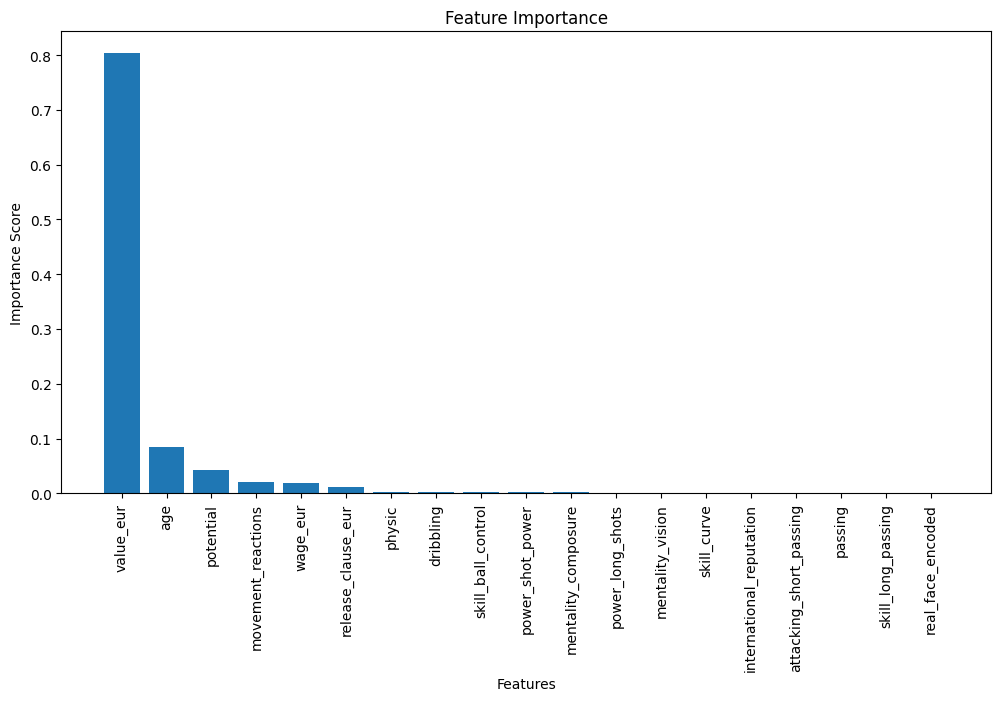

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_rf_model is the best RandomForest model after fine-tuning
feature_importances = best_rf_model.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


#### Select the top five features based on the importance scores in the diagram above

In [25]:
# Select top N important features
top_n_features = 5
important_features = [features[i] for i in indices[:top_n_features]]
print(important_features)
# Update X and X_scaled to keep only the important features
X_important = subset_df[important_features]
X_scaled_important = scaler.fit_transform(X_important)

# Split the updated data into training and testing sets
X_train_important, X_test_important, y_train_important, y_test_important = train_test_split(X_scaled_important, y, test_size=0.2, random_state=42)


['value_eur', 'age', 'potential', 'movement_reactions', 'wage_eur']


In [26]:
subset_df[important_features].describe()

,value_eur,age,potential,movement_reactions,wage_eur
count,1.615830e+05,161583.000000,161583.000000,161583.000000,161583.000000
mean,2.323318e+06,25.123181,70.744008,61.576824,10873.128924
std,5.974905e+06,4.670207,6.259121,9.170063,21860.126433
min,-6.392519e+06,16.000000,40.000000,20.000000,-12552.000000
25%,3.250000e+05,21.000000,66.000000,55.000000,2000.000000
50%,7.250000e+05,25.000000,70.000000,62.000000,4000.000000
75%,1.800000e+06,28.000000,75.000000,68.000000,10000.000000
max,1.940000e+08,54.000000,95.000000,96.000000,575000.000000


#### Train the random forest model with the important features subset

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train the RandomForest model again with important features
rf_model_important = RandomForestRegressor(n_estimators=best_rf_model.n_estimators,
                                           max_depth=best_rf_model.max_depth,
                                           min_samples_split=best_rf_model.min_samples_split,
                                           random_state=42)
rf_model_important.fit(X_train_important, y_train_important)

# Make predictions on the test set
rf_predictions_important = rf_model_important.predict(X_test_important)

# Evaluate the model using MAE and RMSE
rf_test_mae_important = mean_absolute_error(y_test_important, rf_predictions_important)
rf_test_rmse_important = np.sqrt(mean_squared_error(y_test_important, rf_predictions_important))

print("RandomForest Test MAE with Important Features: ", rf_test_mae_important)
print("RandomForest Test RMSE with Important Features: ", rf_test_rmse_important)


RandomForest Test MAE with Important Features:  0.6020668064324468
RandomForest Test RMSE with Important Features:  1.0471804215122142


### 4. Measure the Model's Performance and Fine-Tune

In [33]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Smaller hyperparameter grid for faster search
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Randomized Search with Cross-Validation
n_iter_search = 20  # Reduce the number of iterations

rf_random_search_important = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                                param_distributions=rf_param_grid,
                                                n_iter=n_iter_search,
                                                cv=kfold,
                                                scoring='neg_mean_absolute_error',
                                                n_jobs=-1,
                                                random_state=42)
rf_random_search_important.fit(X_train_important, y_train_important)

print("Best parameters for RandomForest: ", rf_random_search_important.best_params_)
print("Best cross-validation MAE for RandomForest: ", -rf_random_search_important.best_score_)

# Train the best RandomForest model with important features
best_rf_model_important = rf_random_search_important.best_estimator_
best_rf_model_important.fit(X_train_important, y_train_important)

# Make predictions on the test set
rf_predictions_important = best_rf_model_important.predict(X_test_important)

# Evaluate the model using MAE and RMSE
rf_test_mae_important = mean_absolute_error(y_test_important, rf_predictions_important)
rf_test_rmse_important = np.sqrt(mean_squared_error(y_test_important, rf_predictions_important))

print("RandomForest Test MAE with Important Features (after fine-tuning): ", rf_test_mae_important)
print("RandomForest Test RMSE with Important Features (after fine-tuning): ", rf_test_rmse_important)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for RandomForest:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best cross-validation MAE for RandomForest:  0.6218548349488187
RandomForest Test MAE with Important Features (after fine-tuning):  0.5987815859282309
RandomForest Test RMSE with Important Features (after fine-tuning):  1.0241125575821515


## 5. Use the data from another season(players_22) which was not used during the training to test how good is the model.

In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def evaluate_model_with_new_data(filename, best_rf_model, important_features, scaler):
    # Load the new dataset
    df = pd.read_csv(filename)  # Modify as needed based on your file format

    # Assuming 'overall' is the target variable
    X_22 = df[important_features]  # Use the same important features

    # Impute missing values in X_22 if any
    imputer = SimpleImputer(strategy='mean')  # You can use other strategies as well
    X_22_imputed = imputer.fit_transform(X_22)

    # Scale the independent variables using the provided scaler
    X_scaled_22 = scaler.transform(X_22_imputed)  # Assuming 'scaler' is already fitted

    # Make predictions using the best RandomForest model
    rf_predictions_22 = best_rf_model.predict(X_scaled_22)

    # Calculate evaluation metrics (MAE and RMSE)
    # Assuming 'y_22' is the actual target values from the new dataset
    y_22 = df['overall']  # Adjust this based on your dataset structure

    mae_22 = mean_absolute_error(y_22, rf_predictions_22)
    rmse_22 = np.sqrt(mean_squared_error(y_22, rf_predictions_22))

    # Display informative messages
    print(f"Evaluation results for dataset '{filename}':")
    print(f"Mean Absolute Error (MAE): {mae_22:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_22:.4f}")
    print("\nPredictions:")
    print(rf_predictions_22)

    return rf_predictions_22, mae_22, rmse_22

# Example usage:
# Assuming 'best_rf_model_important', 'important_features', and 'scaler' are defined previously
filename = '/content/drive/My Drive/Colab Notebooks/content/players_22.csv'  # Replace with your file path
predictions, mae, rmse = evaluate_model_with_new_data(filename, best_rf_model_important, important_features, scaler)


<ipython-input-34-708aeba03831>:10: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)  # Modify as needed based on your file format
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Evaluation results for dataset '/content/drive/My Drive/Colab Notebooks/content/players_22.csv':
Mean Absolute Error (MAE): 0.4002
Root Mean Squared Error (RMSE): 0.7729

Predictions:
[92.41950216 91.72403571 90.88575    ... 47.02968615 47.51802381
 47.56028571]


***CONCLUSION***: The values of 0.4002 for MAE and 0.7729 for RMSE suggest that the model's predictions are relatively close to the actual values on average.
These metrics provide confidence that the model is making predictions with reasonable accuracy.

### SAVE THE MODEL AS A PICKLE FILE

In [35]:

import joblib

# Assuming best_rf_model is your trained RandomForestRegressor model
filename = '/content/drive/My Drive/Colab Notebooks/content/rf_model.pkl'
joblib.dump(best_rf_model_important, filename)


['/content/drive/My Drive/Colab Notebooks/content/rf_model.pkl']